In [8]:
# Import internal libraries
import glob

# Import external libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [11]:
# Analyze reliability, bandwidth, energy
data = []
datadir = "data"
for bpc in range(1, 3):
    for att in range(16, 256, 32):
        # Real max attempts
        att = (att & 31) << (att >> 5)

        # Load and compute data
        try:
            postread = np.loadtxt(f"{datadir}/postread_{bpc}bpc_slowest_{att}.csv", delimiter=',', dtype=np.int8)
            dt = np.loadtxt(f"{datadir}/dt_{bpc}bpc_slowest_{att}.csv", delimiter=',')
            ivdd_and_dac = np.loadtxt(f"{datadir}/vdd_and_dac_power_{bpc}bpc_slowest_{att}.csv", delimiter=',')
            ivsa = np.loadtxt(f"{datadir}/vsa_power_{bpc}bpc_slowest_{att}.csv", delimiter=',')
            ivddio = np.loadtxt(f"{datadir}/vddio_power_{bpc}bpc_slowest_{att}.csv", delimiter=',')
            ivddio_dac = np.loadtxt(f"{datadir}/vddio_power_{bpc}bpc_slowest_{att}.csv", delimiter=',')
        except OSError:
            try:
                postread = np.loadtxt(f"{datadir}/postread_{bpc}bpc_slow_{att}.csv", delimiter=',', dtype=np.int8)
                dt = np.loadtxt(f"{datadir}/dt_{bpc}bpc_slow_{att}.csv", delimiter=',')
                ivdd_and_dac = np.loadtxt(f"{datadir}/vdd_and_dac_power_{bpc}bpc_slow_{att}.csv", delimiter=',')
                ivsa = np.loadtxt(f"{datadir}/vsa_power_{bpc}bpc_slow_{att}.csv", delimiter=',')
                ivddio = np.loadtxt(f"{datadir}/vddio_power_{bpc}bpc_slow_{att}.csv", delimiter=',')
                ivddio_dac = np.loadtxt(f"{datadir}/vddio_power_{bpc}bpc_slow_{att}.csv", delimiter=',')
            except OSError:
                continue
        power_tot = ivdd_and_dac * 0.9 + ivsa * 0.9 + ivddio_dac * 3.3 + ivddio * 3.3
        energy_tot = power_tot * dt
        bw = 2**16 * 48 * bpc / dt # bits per second
        energy_per_bit = energy_tot / 2**16 / 48 / bpc
        edp = energy_per_bit / bw

        # Load data into confmat
        confmat = np.zeros(shape=(2**bpc, 2**bpc))
        for i in range(65536):
            for j in range(48):
                if j in [19,24,29,38,43]:
                    continue
                confmat[j % (2**bpc)][postread[i][j]] += 1
        confmat = confmat.astype(int)
        print(confmat)

        # Symbol error magnitudes
        mae = sum(abs(i - j) * confmat[i][j] for i in range(2**bpc) for j in range(2**bpc)) / confmat.sum()
        rmse = np.sqrt(sum((i - j)**2 * confmat[i][j] for i in range(2**bpc) for j in range(2**bpc)) / confmat.sum())

        # Function to get Gray code string
        getgray = lambda x : format(2**(2**bpc) + x^x//2, f"0{2**bpc-1}b")[1:]

        # Function to get Gray code error rate for each possible symbol confusion
        grayerr = np.array([[sum([int(ic != jc) for ic, jc in zip(getgray(i), getgray(j))]) for i in range(2**bpc)] for j in range(2**bpc)]) / bpc

        # BER and CER
        ber = (grayerr * confmat).sum() / confmat.sum()
        cer = 1 - confmat.trace() / confmat.sum()
        
        # Compose dataframe
        data.append({"att": att, "bpc": bpc, "dt": dt, "power_tot": power_tot, "energy_per_bit": energy_per_bit, "edp": edp, "bw": bw, "cer": cer, "ber": ber, "mae": mae, "rmse": rmse})
data = pd.DataFrame(data)
data

[[1145675  296117]
 [    307 1375949]]
[[1431289   10503]
 [     88 1376168]]
[[1294865  146927]
 [   4786 1371470]]
[[1339649  102143]
 [    331 1375925]]
[[1374523   67269]
 [     24 1376232]]
[[1378485   63307]
 [     17 1376239]]
[[1379457   62335]
 [     17 1376239]]
[[1377847   63945]
 [     23 1376233]]
[[536522  75700  84384  24290]
 [ 98783 425245  69945 126923]
 [  6000  36394 444824 233678]
 [   210    733  15060 639357]]
[[543598  28543  95850  52905]
 [134213 401435 101118  84130]
 [  8107  59946 487219 165624]
 [   334   1631  17764 635631]]
[[547187  16966  90950  65793]
 [ 78249 481061  85276  76310]
 [  2763  23183 523096 171854]
 [   120    158  10466 644616]]
[[550599  16367  85043  68887]
 [ 39965 547898  72960  60073]
 [   346   5524 570127 144899]
 [     4     16   7306 648034]]
[[551238  22041  77847  69770]
 [ 17929 608873  56809  37285]
 [   103   2255 619020  99518]
 [     0     20   5163 650177]]
[[549287  39296  64872  67441]
 [  6298 662546  35072  16980]
 

,att,bpc,dt,power_tot,energy_per_bit,edp,bw,cer,ber,mae,rmse
0,16,1,0.2783806324005127,0.006763,5.985023e-10,5.296435e-17,1.130010e+07,0.105188,0.105188,0.105188,0.324327
1,32,1,0.35916948318481445,0.006920,7.900842e-10,9.020937e-17,8.758339e+06,0.003758,0.003758,0.003758,0.061305
2,64,1,0.756061315536499,0.006889,1.655799e-09,3.979636e-16,4.160678e+06,0.053836,0.053836,0.053836,0.232026
3,128,1,1.1269779205322266,0.006778,2.428092e-09,8.698801e-16,2.791295e+06,0.036363,0.036363,0.036363,0.190692
4,256,1,1.470289945602417,0.006659,3.112516e-09,1.454767e-15,2.139529e+06,0.023879,0.023879,0.023879,0.154529
5,512,1,2.010216236114502,0.006498,4.152595e-09,2.653635e-15,1.564870e+06,0.022471,0.022471,0.022471,0.149903
6,1024,1,2.7730751037597656,0.006306,5.558873e-09,4.900352e-15,1.134383e+06,0.022126,0.022126,0.022126,0.148748
7,2048,1,3.3498194217681885,0.006290,6.698277e-09,7.132854e-15,9.390739e+05,0.022699,0.022699,0.022699,0.150663
8,16,2,0.7504391670227051,0.005696,6.793819e-10,8.103606e-17,8.383699e+06,0.273984,0.175678,0.368745,0.758719
9,32,2,1.2151477336883545,0.005686,1.098257e-09,2.121202e-16,5.177524e+06,0.266200,0.166761,0.371307,0.786959


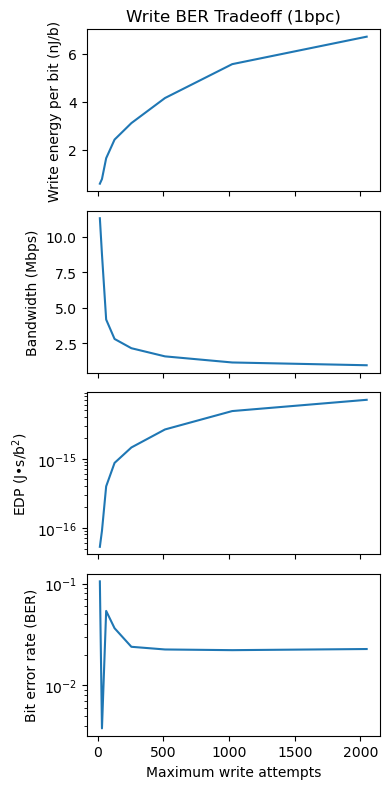

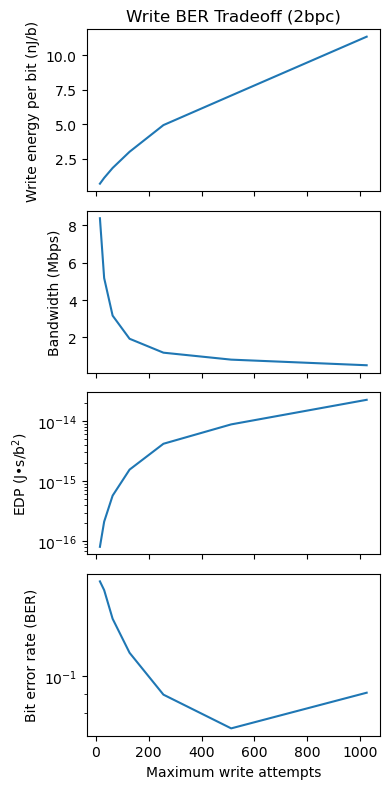

In [12]:
# Plot write BER tradeoff vs. attempts
for bpc, d in data.groupby("bpc"):
    fig, axs = plt.subplots(4, 1, figsize=(4,8), sharex=True)
    plt.xlabel("Maximum write attempts")
    axs[0].set_title(f"Write BER Tradeoff ({bpc}bpc)")
    axs[0].plot(d["att"], d["energy_per_bit"]*1e9)
    axs[0].set_ylabel("Write energy per bit (nJ/b)")
    axs[1].plot(d["att"], d["bw"]/1e6)
    # axs[1].set_yscale("log")
    axs[1].set_ylabel("Bandwidth (Mbps)")
    axs[2].plot(d["att"], d["edp"])
    axs[2].set_yscale("log")
    axs[2].set_ylabel("EDP (J•s/b$^2$)")
    axs[3].plot(d["att"], d["ber"])
    axs[3].set_yscale("log")
    axs[3].set_ylabel("Bit error rate (BER)")
    plt.tight_layout()
    plt.savefig(f"../analysis/figs/{bpc}bpc_write_ber_tradeoff.pdf")
    plt.show()